In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp
import scipy.stats as ss
import scipy as sc

# Blockchain queue

Blockchain efficiency is characterized by the 
- throughput (how many transactions are confirmed per time unit) 
- latency (the average confirmation time of a transaction). 

These quantities are studied within the frame of a queueing model. 

- The pending transactions arrive at a Poisson rate $\lambda$ to form a queue, 
- a fixed number $b$ (the first which entered the queue) will be processed in a block. 
- The block generation time has distribution $G$ on $\mathbb{R}_+$. 

The result is a $M/G^b/1$ queue. 

We are going to simulate trajectories of this process to study the average confirmation time and the number of pending transaction in the queue at stationarity. 

Let us assume that $G$ is exponential with mean $1/\mu$, which corresponds to the empirical data on the block arrival time in the bitcoin blockchain.

Denote by $(S_i)$ the transaction arrival time and $(T_i)$ the blockarrival times.

We denote by $N_t$ the number of transaction and $M_t$ the number of block up to time $t>0$. Both of the processes are Poisson process with respective intensity $\lambda$ and $\mu$.

In [2]:
# Parameters of the transaction arrival, the block size and the service time
μ, λ, b = 1, 2, 4
print("stationarity condition holds? "+ str(λ < b * μ) )
# We set a time horizon, the higher the better to reach stationarity
t = 10000
# Number of transactions issued and number of blocks generated
N_t, M_t = np.random.poisson(λ * t), np.random.poisson(μ * t)
# Transaction and block arrival times
S, T = np.sort(np.random.uniform(low = 0, high = t, size = N_t)), np.sort(np.random.uniform(low = 0, high = t, size = M_t))
T = np.insert(T, 0, 0)

stationarity condition holds? True


In [3]:
queue = np.array([])
server = []
conf_time = []
for k in range(len(T)-1):    
    queue = np.append(queue, S[np.logical_and(S>T[k], S < T[k+1])])
    if len(queue) > b:
        conf_time.append(np.sum(T[k+1] - queue[:b]))
        server.append(b)
        queue = queue[b:]
    else:
        if len(queue) > 0:
            conf_time.append(np.sum(T[k+1] -queue))
            server.append(len(queue))
            queue = np.array([])
        else:
            server.append(0)


In [4]:
print(np.sum(conf_time) / sum(S < T[-1]), μ * np.mean(server))

1.45198945991577 2.0158552698444963


Theoreticaly the mean confirmation time is given by 

$$
\frac{p}{(1-p)\lambda}
$$
where $p=1/z^\ast$ and $z^\ast$ is the only root to 
$$
-\frac{\lambda}{\mu}z^{b+1}+z^b\left(\frac{\lambda}{\mu}+1\right) - 1,
$$
such that $|z^\ast$|>1.

In [5]:
def f(x):
    return(- λ / μ *x**(b+1) + x**b * (λ / μ + 1) - 1 )

sol = sc.optimize.root_scalar(f, bracket=[1.00001, 100000], method='brentq')
p = 1/sol.root
geom_pmf = np.array([p**k * (1-p) for k in np.arange(0,b+1)])
latency, throughput = p/(1-p)/λ, μ*(sum(np.arange(0,b+1) * geom_pmf) + p**(b+1)*b)

print(latency, throughput)

1.4325233242764148 1.9999999999999987


What is the server occupancy?

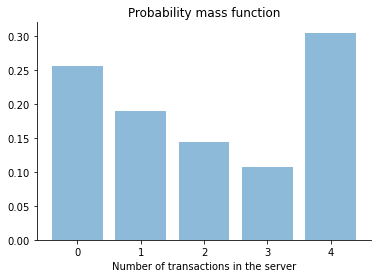

In [6]:
# sum(server == 0)/len(server)
plt.bar(np.arange(0, b+1,1), np.array([np.mean(np.array(server)==k) for k in range(b+1)]), alpha = 0.5)
plt.xticks(np.arange(0, b+1,1))
plt.xlabel('Number of transactions in the server')
plt.title('Probability mass function')
sns.despine()